In [1]:
#Neural network program using Long Short Term Memory (LSTM) to predict future stock prices

In [2]:
#Download Libraries (Downloads libraries to your computer automatically)
'''import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install beautifulsoup4
!{sys.executable} -m pip install datetime'''

#Import Libraries (Import libraries to this program)
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import seaborn as sns
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [3]:
#Gather current date
today = datetime.today().strftime('%Y-%m-%d')
six_months_ago =  datetime.today() - timedelta(days = 252)
two_years_ago =  datetime.today() - timedelta(days = 252*2)
start_date = "2015-1-1"
future_date = datetime.today() + timedelta(days = 252)
future_date = future_date.strftime('%Y-%m-%d')
#data = pd.DataFrame()

In [4]:
#Function to import stock data
def import_stock_data(tickers, start, end):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = web.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = web.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [5]:
#List and plot stocks to research
ticker =['AAPL','MSFT','BILI','SNAP']
stocks_df = import_stock_data(ticker, start_date, today)
'''print(future_date)
plt.plot(stocks_df)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price', fontsize = 16)
plt.show()'''

#Get the number of rows and columns
#stocks_df.shape

#Convert stock data to numpy array
#clean_stocks_df = stocks_df.dropna()
#dataset = clean_stocks_df.values
#print(stocks_df[stocks_df.columns[2]])

"print(future_date)\nplt.plot(stocks_df)\nplt.xlabel('Date', fontsize = 16)\nplt.ylabel('Price', fontsize = 16)\nplt.show()"

In [6]:
#30 Day Simple Moving Average
def SMA_20(data):
    SMA_20 = data.rolling(window = 20).mean()
    SMA_20 = SMA_20.dropna()
    SMA_20 = pd.DataFrame(SMA_20)
    return SMA_20

#100 Day Simple Moving Average
def SMA_100(data):
    SMA_100 = data.rolling(window = 100).mean()
    SMA_100 = SMA_100.dropna()
    SMA_100 = pd.DataFrame(SMA_100)
    return SMA_100


In [7]:
#Function for the Long Short-Term Memory artificital recurrent neural network
def LSTM_model(df, batchsize, iterations, plot_prediction=True):
    clean_stocks_df = df.dropna()
    dataset = clean_stocks_df.values.reshape(-1,1)
    print(dataset)
    
    #Get 80% of the number of rows to train the model
    training_data_len = math.ceil(len(dataset) * .8)
    
    #Scale the data to apply preprocessing transformers to the imported data before implementing in neural network
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    #Create training dataset
    train_data = scaled_data[0:training_data_len , :]
    
    #Split the data into x_train and y_train data sets
    x_train = [] #x_train is independent variables, so date in this case
    y_train = [] #y_train is dependent variables, so price in this case
    
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])
        
    #Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Train the model
    model.fit(x_train, y_train, batch_size=batchsize, epochs=iterations)
    
    #Create the testing data set
    test_data = scaled_data[training_data_len - 60:, :]

    #Create the data sets x_test and y_test to verify data
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_test = np.array(x_test)

    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    #Get the Root Mean Squre Error (RMSE)
    rmse = np.sqrt(np.mean(predictions-y_test)**2)
    
    '''#### Future Predictions #####
    #Create the data sets x_test and y_test to predict future data
    x_future = []
    y_future = dataset[training_data_len:, :]
    for i in range(60, len(test_data)+252):
        x_future.append(test_data[i-60:i, 0])
        
    #Convert the data to a numpy array
    x_future = np.array(x_future)

    #Reshape the data
    x_future = np.reshape(x_future, (x_future.shape[0], x_future.shape[1], 1))
    
    #Get the models predicted price values
    predictions = model.predict(x_future)
    predictions = scaler.inverse_transform(predictions)'''
    
    '''#Plot the data
    if plot_prediction== True:
        train = stocks_df[:training_data_len]
        valid = stocks_df[training_data_len:]
        valid['Predictions']= predictions
        plt.title('Model')
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Close Price USD ($)', fontsize=16)
        plt.plot(train)
        plt.plot(valid)
        plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
        plt.show()'''
    
    return predictions, rmse, training_data_len


In [8]:
#### Error with prediction values in graph. Index of 'Prediction' values does not have a designated date ####
#### Need to index the 'Prediction' values to match the index of 'Valid' values ###

'''#Show the valid and predicted prices
for i in range(0,len(stocks_df.columns)):
    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["Predictions"]
    print("Predictions:",predictions)
    train = stocks_df[stocks_df.columns[i]][:training_data_len]
    train = pd.DataFrame(train)
    train.columns = ["Train"]
    valid = stocks_df[stocks_df.columns[i]][training_data_len:]
    valid = pd.DataFrame(valid)
    valid.columns = ["Valid"]
    print("Train:",train)
    print("Valid:", valid)
    valid['Predictions']= predictions
    plt.title('Model')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Close Price USD ($)', fontsize=16)
    plt.plot(train)
    plt.plot(valid)
    plt.plot(predictions)
    plt.legend(['Train', 'Validation','Predictions'], loc='upper left')
    plt.show()
    print(ticker[i])
    print(rmse)'''

'#Show the valid and predicted prices\nfor i in range(0,len(stocks_df.columns)):\n    predictions, rmse, training_data_len = LSTM_model(stocks_df[stocks_df.columns[i]], batchsize=1, iterations=1)\n    predictions = pd.DataFrame(predictions)\n    predictions.columns = ["Predictions"]\n    print("Predictions:",predictions)\n    train = stocks_df[stocks_df.columns[i]][:training_data_len]\n    train = pd.DataFrame(train)\n    train.columns = ["Train"]\n    valid = stocks_df[stocks_df.columns[i]][training_data_len:]\n    valid = pd.DataFrame(valid)\n    valid.columns = ["Valid"]\n    print("Train:",train)\n    print("Valid:", valid)\n    valid[\'Predictions\']= predictions\n    plt.title(\'Model\')\n    plt.xlabel(\'Date\', fontsize=16)\n    plt.ylabel(\'Close Price USD ($)\', fontsize=16)\n    plt.plot(train)\n    plt.plot(valid)\n    plt.plot(predictions)\n    plt.legend([\'Train\', \'Validation\',\'Predictions\'], loc=\'upper left\')\n    plt.show()\n    print(ticker[i])\n    print(rmse)

In [9]:
'''predictions_df= pd.DataFrame(predictions)
SMA_20_df = SMA_20(predictions_df)
#print(SMA_20_df)

SMA_100_df = SMA_100(predictions_df)
#print(SMA_100_df)

plt.plot(predictions_df)
plt.plot(SMA_20_df)
plt.plot(SMA_100_df)
plt.title('SMA Return Prediction')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')
plt.show()'''

"predictions_df= pd.DataFrame(predictions)\nSMA_20_df = SMA_20(predictions_df)\n#print(SMA_20_df)\n\nSMA_100_df = SMA_100(predictions_df)\n#print(SMA_100_df)\n\nplt.plot(predictions_df)\nplt.plot(SMA_20_df)\nplt.plot(SMA_100_df)\nplt.title('SMA Return Prediction')\nplt.xlabel('Date', fontsize=16)\nplt.ylabel('Close Price USD ($)', fontsize=16)\nplt.legend(['Price Prediction','20 Day SMA', '100 Day SMA'], loc='upper left')\nplt.show()"

In [10]:
#Program to use the three moving average crossover strategy to determine when to buy and sell stock
stocks_df = import_stock_data(ticker, start_date, today)
'''plt.title(ticker)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(stocks_df)
plt.show()'''

"plt.title(ticker)\nplt.xlabel('Date', fontsize=16)\nplt.ylabel('Price', fontsize=16)\nplt.plot(stocks_df)\nplt.show()"

In [11]:
#Calculate the three moving averages

#Gather stock data
two_years_ago =  datetime.today() - timedelta(days = 504)

def EMA_calculations(ticker):
    stocks_df = import_stock_data(i, two_years_ago, today)
    #print(stocks_df[i])
    ShortEMA = 0
    MiddleEMA = 0
    LongEMA = 0
    #Short/Fast Exponential Moving Average (5 Day EMA)
    ShortEMA = stocks_df[i].ewm(span=5, adjust=False).mean()

    #Middle/Medium Exponential Moving Average (21 Day EMA)
    MiddleEMA = stocks_df[i].ewm(span=21, adjust=False).mean()

    #Long/Slow Exponential Moving Average (63 Day EMA)
    LongEMA = stocks_df[i].ewm(span=63, adjust = False).mean()

    '''#Visualize Closing Price and Exponential Moving Averages
    plt.title(ticker)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.plot(stocks_df, color='blue')
    plt.plot(ShortEMA, color='red')
    plt.plot(MiddleEMA, color='orange')
    plt.plot(LongEMA, color='green')
    plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
    plt.show()'''

    #Add EMA to the dataset
    stocks_df['Short EMA']=ShortEMA
    stocks_df['Middle EMA']=MiddleEMA
    stocks_df['Long EMA']=LongEMA
    #print(stocks_df)
    

    '''#Show Data
    stocks_df = pd.DataFrame(stocks_df)
    print(stocks_df)
    stocks_df.iloc[0,0]
    stocks_df.iloc[1,1]
    #stocks_df[ticker][0,2]'''
    return stocks_df, ShortEMA, MiddleEMA, LongEMA


In [12]:
#Function to indicate when to buy and sell stocks
def buy_sell_indicators(data, ticker):
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False
    #print(data)
    #print(data[ticker])
    #print(len(data))
    
    for i in range(0, len(data)):
        
        #Buy when Middle EMA crosses below Long EMA and Short EMA crosses Middle EMA
        if data.iloc[i,2] < data.iloc[i,3] and data.iloc[i,1] < data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_short = True
        
        #Sell when Short EMA crosses Middle EMA
        elif flag_short == True and data.iloc[i,1] > data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_short = False
            
        #Buy when Long EMA crosses below Middle EMA and Middle EMA crosses Short EMA
        elif data.iloc[i,2] > data.iloc[i,3] and data.iloc[i,1] > data.iloc[i,2] and flag_long == False and flag_short == False:
            #buy_list.append(data[ticker][i])
            buy_list.append(data.iloc[i,0])
            sell_list.append(np.nan)
            flag_long = True
        
        #Sell when Middle EMA crosses Short EMA
        elif flag_long == True and data.iloc[i,1] < data.iloc[i,2]:
            #sell_list.append(data[ticker][i])
            sell_list.append(data.iloc[i,0])
            buy_list.append(np.nan)
            flag_long = False
            
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return buy_list, sell_list
            

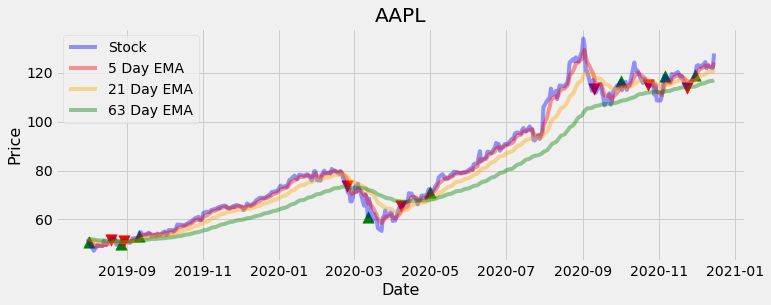

     Index        Buy  Sell
0        0        NaN   NaN
1        1  50.895054   NaN
2        2        NaN   NaN
3        3        NaN   NaN
4        4        NaN   NaN
..     ...        ...   ...
344    344        NaN   NaN
345    345        NaN   NaN
346    346        NaN   NaN
347    347        NaN   NaN
348    348        NaN   NaN

[349 rows x 3 columns]


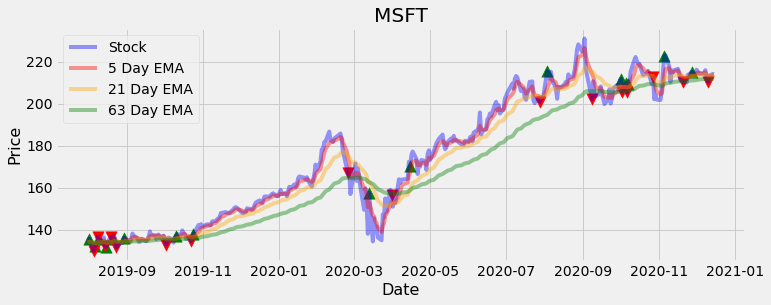

     Index         Buy        Sell
0        0         NaN         NaN
1        1  135.697617         NaN
2        2         NaN         NaN
3        3         NaN  129.947739
4        4  132.385284         NaN
..     ...         ...         ...
344    344         NaN         NaN
345    345         NaN  210.520004
346    346         NaN         NaN
347    347         NaN         NaN
348    348         NaN         NaN

[349 rows x 3 columns]


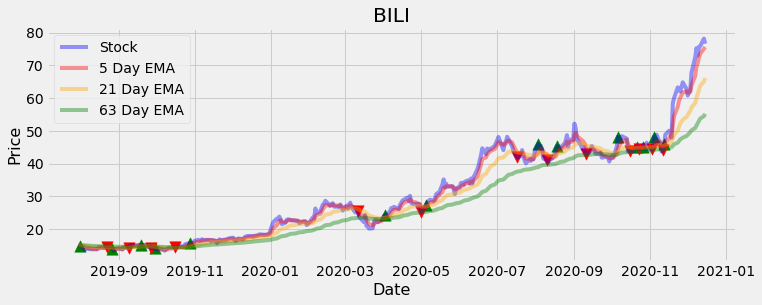

     Index    Buy  Sell
0        0    NaN   NaN
1        1  14.75   NaN
2        2    NaN   NaN
3        3    NaN   NaN
4        4    NaN   NaN
..     ...    ...   ...
344    344    NaN   NaN
345    345    NaN   NaN
346    346    NaN   NaN
347    347    NaN   NaN
348    348    NaN   NaN

[349 rows x 3 columns]


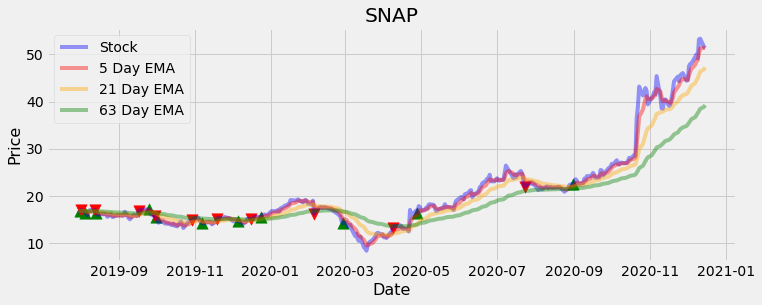

     Index        Buy       Sell
0        0        NaN        NaN
1        1  16.680000        NaN
2        2        NaN  17.030001
3        3  16.459999        NaN
4        4        NaN        NaN
..     ...        ...        ...
344    344        NaN        NaN
345    345        NaN        NaN
346    346        NaN        NaN
347    347        NaN        NaN
348    348        NaN        NaN

[349 rows x 3 columns]


In [13]:
#Add buy and sell signals to dataset
#stocks_df['Buy'], stocks_df['Sell'] = buy_sell_indicators(stocks_df, ticker)
#stock_df['Sell'] = buy_sell_indicators(stocks_df, ticker)[1]

#Visualize Closing Price and Exponential Moving Averages
def plot_EMA_indicators(stocks_df, ticker, ShortEMA, MiddleEMA, LongEMA, plot = True):
    price_list=[]
    ShortEMA_list=[]
    MiddleEMA_list=[]
    LongEMA_list=[]
    Buy_list=[]
    Sell_list=[]
    for i in range(0,len(stocks_df)):
        price_list.append(stocks_df.iloc[i,0])
        ShortEMA_list.append(stocks_df.iloc[i,1])
        MiddleEMA_list.append(stocks_df.iloc[i,2])
        LongEMA_list.append(stocks_df.iloc[i,3])
        Buy_list.append(stocks_df.iloc[i,4])
        Sell_list.append(stocks_df.iloc[i,5])
     
    #stocks_df.values
    #print(stocks_df)
    if plot == True:
        plt.figure(figsize=(11,4))
        plt.title(ticker)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.plot(stocks_df[ticker], color='blue', alpha = 0.4)
        plt.plot(ShortEMA, color='red', alpha = 0.4)
        plt.plot(MiddleEMA, color='orange',alpha = 0.4)
        plt.plot(LongEMA, color='green', alpha = 0.4)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.legend(['Stock', '5 Day EMA','21 Day EMA', '63 Day EMA'], loc='upper left')
        plt.show()

    #Buy_list_df = pd.DataFrame(Buy_list)
    #Buy_list_df = Buy_list_df.dropna()
    #Buy_sum = Buy_list_df.sum()
    #Sell_list_df = pd.DataFrame(Sell_list)
    #Sell_list_df = Sell_list_df.dropna()
    #Sell_sum = Sell_list_df.sum()  
    
    return Buy_list, Sell_list


Buy_Sell_df = pd.DataFrame()
for i in ticker:
    #print(i)
    stocks_df,ShortEMA, MiddleEMA, LongEMA = EMA_calculations(ticker)
    #print(stocks_df)
    
    index_list = []
    for n in range(0,len(stocks_df)):
        index_list.append(n)
    
    Buy_Sell_df['Index']= index_list
    
    stocks_df['Buy'], stocks_df['Sell'] = buy_sell_indicators(stocks_df, i)
    Buy_Sell_df['Buy'], Buy_Sell_df['Sell'] = plot_EMA_indicators(stocks_df, i, ShortEMA, MiddleEMA, LongEMA, plot = True)
    
    #print('\n',i,"Buy Price\n",Buy_list_df)
    print(Buy_Sell_df)
    #print('\n',i,"Sell Price\n",Sell_list_df)
    #Buy_Sell_df['Buy Price']=Buy_list_df
    #Buy_Sell_df['Buy Price']=Sell_list_df
    #print(Buy_Sell_df)

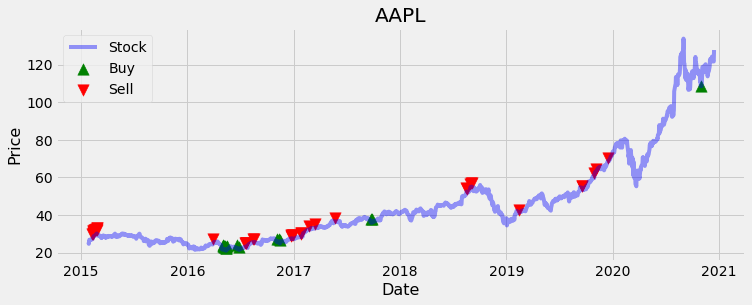

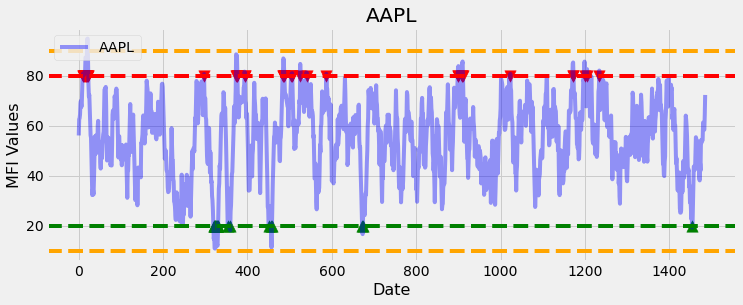

AAPL                   High         Low        Open       Close       Volume  \
Date                                                                      
2015-01-23   28.437500   27.882500   28.075001   28.245001  185859200.0   
2015-01-26   28.590000   28.200001   28.434999   28.275000  222460000.0   
2015-01-27   28.120001   27.257500   28.105000   27.285000  382274800.0   
2015-01-28   29.530001   28.827499   29.407499   28.827499  585908400.0   
2015-01-29   29.797501   28.889999   29.080000   29.725000  337745600.0   
...                ...         ...         ...         ...          ...   
2020-12-09  125.949997  121.000000  124.529999  121.779999  115089200.0   
2020-12-10  123.870003  120.150002  120.500000  123.239998   81312200.0   
2020-12-11  122.760002  120.550003  122.430000  122.410004   86939800.0   
2020-12-14  123.349998  121.540001  122.599998  121.779999   79184500.0   
2020-12-15  127.900002  124.129997  124.339996  127.879997  150402367.0   

             Adj Cl

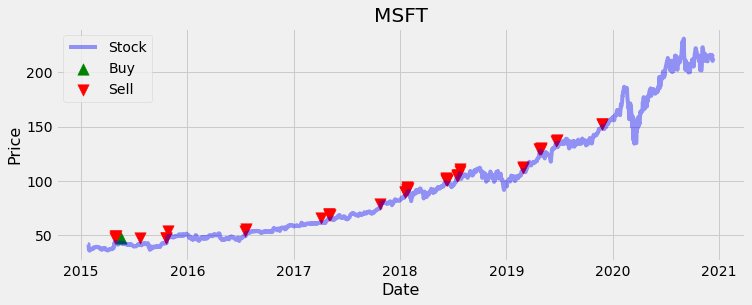

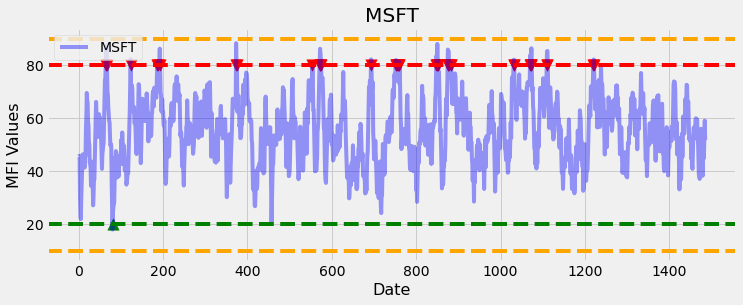

MSFT                   High         Low        Open       Close       Volume  \
Date                                                                      
2015-01-23   47.389999   46.799999   47.360001   47.180000   26211600.0   
2015-01-26   47.130001   46.240002   47.000000   47.009998   42525500.0   
2015-01-27   43.200001   42.110001   42.950001   42.660000  169164000.0   
2015-01-28   42.790001   41.160000   42.740002   41.189999   84507100.0   
2015-01-29   42.119999   40.790001   40.930000   42.009998   63585300.0   
...                ...         ...         ...         ...          ...   
2020-12-09  215.229996  211.210007  215.160004  211.800003   32440600.0   
2020-12-10  213.080002  210.360001  211.770004  210.520004   26733300.0   
2020-12-11  213.320007  209.110001  210.050003  213.259995   30979400.0   
2020-12-14  216.210007  212.880005  213.100006  214.199997   28785700.0   
2020-12-15  215.399994  212.240005  215.164993  214.130005   24068658.0   

             Adj Cl

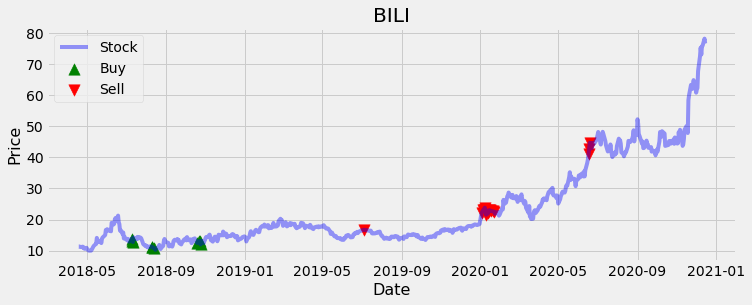

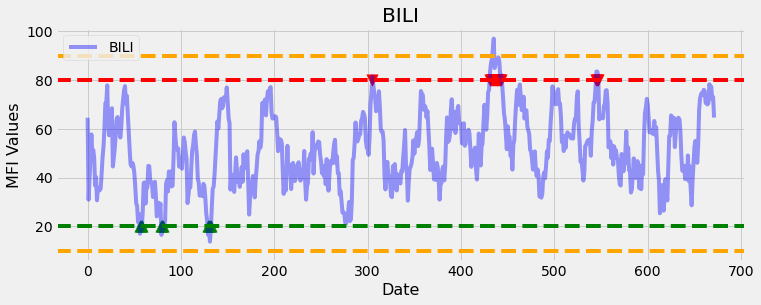

BILI                  High        Low       Open      Close   Volume  Adj Close  \
Date                                                                         
2018-04-18  11.500000  11.290000  11.440000  11.350000   582400  11.350000   
2018-04-19  11.490000  11.280000  11.400000  11.350000   433000  11.350000   
2018-04-20  11.310000  11.060000  11.250000  11.190000   625700  11.190000   
2018-04-23  11.460000  11.051000  11.290000  11.190000   867800  11.190000   
2018-04-24  11.520000  11.210000  11.250000  11.290000  1223300  11.290000   
...               ...        ...        ...        ...      ...        ...   
2020-12-09  77.930000  71.889999  77.279999  73.059998  6385900  73.059998   
2020-12-10  75.970001  71.922997  72.669998  75.709999  4289000  75.709999   
2020-12-11  81.980003  75.190002  76.489998  75.910004  9424500  75.910004   
2020-12-14  80.870003  77.040001  78.405998  78.199997  5016900  78.199997   
2020-12-15  80.800003  76.000000  80.650002  76.660004  381

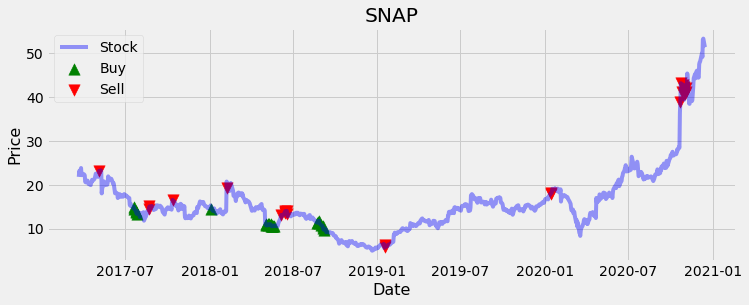

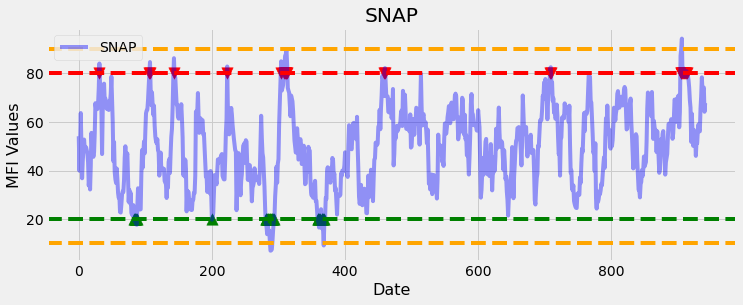

SNAP                  High        Low       Open      Close    Volume  Adj Close  \
Date                                                                          
2017-03-22  22.250000  20.520000  20.650000  21.820000  47599300  21.820000   
2017-03-23  23.299999  22.219999  22.690001  23.129999  40645400  23.129999   
2017-03-24  23.100000  22.340000  23.049999  22.740000  17263200  22.740000   
2017-03-27  24.400000  22.600000  23.090000  23.830000  48398200  23.830000   
2017-03-28  23.360001  22.170000  23.309999  22.209999  49889900  22.209999   
...               ...        ...        ...        ...       ...        ...   
2020-12-09  50.977001  48.459999  50.000000  49.150002  18354700  49.150002   
2020-12-10  53.264999  48.599998  48.849998  53.150002  31519700  53.150002   
2020-12-11  53.849998  51.880001  52.880001  53.330002  26837700  53.330002   
2020-12-14  53.730000  51.278000  53.680000  51.599998  18920900  51.599998   
2020-12-15  52.654499  51.130001  51.790001  51

In [14]:
#Money Flow Index (MFI) Strategy - Uses Price and Volume to determine if s stock is being overbought or oversold

#Gather stock data
#ticker = ['AAPL','TSLA']
#df=pd.DataFrame()
#stocks_df=pd.DataFrame()

#Create a function to get the buy and sell signals
def get_MFI_buy_sell_signals(data, high, low):
    buy_signal = []
    sell_signal = []
    buy_location = []
    sell_location = [] 
        
    for i in range(len(data['MFI'])):
        if data['MFI'][i] > high:
            buy_signal.append(np.nan)
            buy_location.append(np.nan)
            sell_signal.append(data['Close'][i])
            sell_location.append(high)
        elif data['MFI'][i] < low:
            sell_signal.append(np.nan)
            sell_location.append(np.nan)
            buy_signal.append(data['Close'][i])
            buy_location.append(low)
        else:
            sell_signal.append(np.nan)
            sell_location.append(np.nan)
            buy_signal.append(np.nan)
            buy_location.append(np.nan)
                
    return buy_signal, sell_signal, buy_location, sell_location

def calculate_MFI(ticker, plot=True):
    #print(ticker)
    df= web.DataReader(ticker, data_source='yahoo', start=start_date)
    #if plot == True:
        #plt.figure(figsize=(11,4))
        #plt.title(t)
        #plt.xlabel('Date', fontsize=16)
        #plt.ylabel('Price', fontsize=16)
        #plt.plot(df['Adj Close'], color='blue', alpha = 0.4)
        #plt.legend(['Stock'], loc='upper left')
        #plt.show()
        #print(t,df)
        #data_list.append(df)
    
    #Calculate the typical price
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    #print('Typical Price\n',typical_price)
    
    #Get the period
    period = 14
    
    #Calculate the money flow
    money_flow = typical_price * df['Volume']
    #print('Money Flow\n',money_flow)
    
    #Get all of the positive and negative money flows
    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
        else:
            positive_flow.append(0)
            negative_flow.append(0)
        
    #Get all the positive and negative money flows within the time period
    positive_mf = []
    negative_mf = []
    
    for i in range(period-1, len(positive_flow)):
        positive_mf.append(sum(positive_flow[i+1-period : i+1]))
    for i in range(period-1, len(negative_flow)):
        negative_mf.append(sum(negative_flow[i+1-period : i+1]))
        
    #Calculat the Money Flow Index (MFI)
    MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    #print(MFI)
    
    #Create a new data Frame
    new_df = pd.DataFrame()
    new_df = df[period:]
    new_df["MFI"]= MFI
    #print(t,new_df)
        
    #Add new buy and sell columns
    new_df['Buy'] = get_MFI_buy_sell_signals(new_df,80,20)[0]
    new_df['Sell'] = get_MFI_buy_sell_signals(new_df,80,20)[1]
    indicator_df = pd.DataFrame()
    indicator_df['Buy'] = get_MFI_buy_sell_signals(new_df,80,20)[2]
    indicator_df['Sell'] = get_MFI_buy_sell_signals(new_df,80,20)[3]
    #indicator_df.dropna()
    #print(indicator_df)
    #print(new_df['Buy'])
    #print(new_df['Sell'])       
    
    #Show the data
    if plot==True:
        #print(t, new_df)
        plt.figure(figsize=(11,4))
        plt.title(t)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.scatter(new_df.index, new_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(new_df.index, new_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.plot(new_df['Adj Close'], color='blue', alpha = 0.4)
        plt.legend(['Stock','Buy','Sell'], loc='upper left')
        plt.show()
    
        #Plot the MFI
        MFI_df = pd.DataFrame()
        MFI_df["MFI"] = MFI
        plt.figure(figsize=(11,4))
        plt.title(t)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('MFI Values', fontsize=16)
        plt.plot(MFI_df['MFI'], color='blue', alpha = 0.4)
        plt.axhline(10, linestyle= '--', color = 'orange')
        plt.axhline(20, linestyle= '--', color = 'green')
        plt.axhline(80, linestyle= '--', color = 'red')
        plt.axhline(90, linestyle= '--', color = 'orange')
        plt.scatter(MFI_df.index, indicator_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(MFI_df.index, indicator_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.legend([t], loc='upper left')
        plt.show()  
    
    return new_df

for t in ticker:
    #print(t)
    stock_info = calculate_MFI(t,plot=True)
    print(t,stock_info)
    

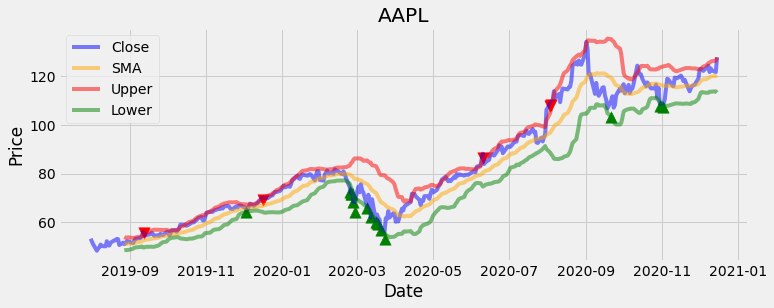

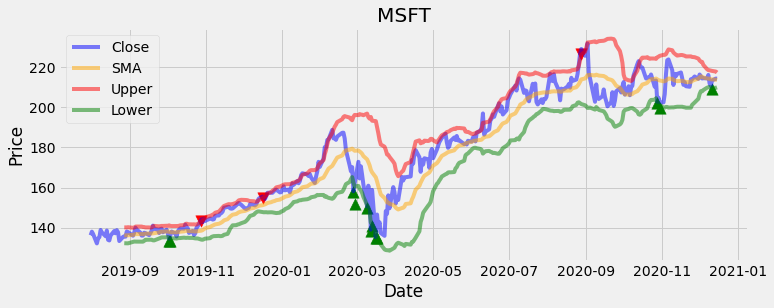

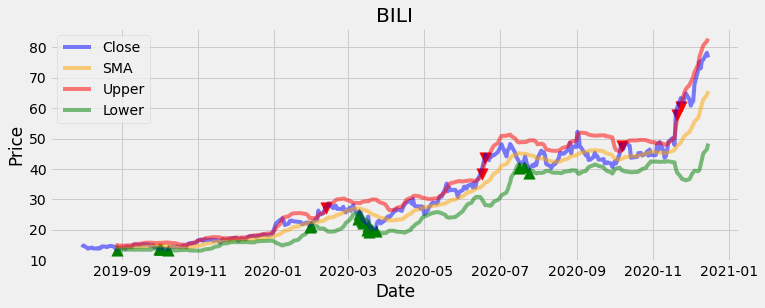

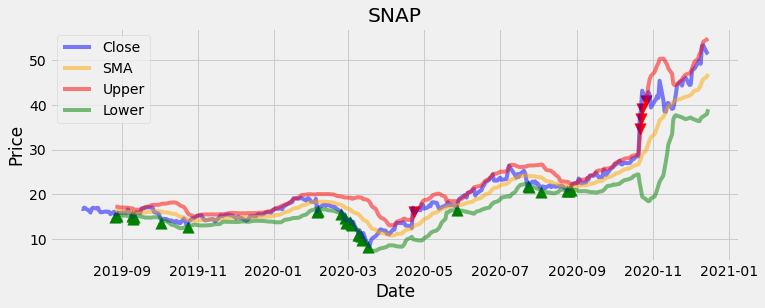

In [15]:
#Bollinger Band Strategy to determine when to buy and sell stock
#Creat a function to get the buy and sell signals
def get_Bollinger_signal(data):
    buy_signal = []
    sell_signal = []
    df= data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    #print("DATA IN FUNCTION\n",df, '\n', df.iloc[:,1])
    
    for i in range(0,len(data)):
        if data.iloc[i,1] > data.iloc[i,8]:
            buy_signal.append(np.nan)
            sell_signal.append(data.iloc[i,1])
        #If the closing price passes the lower band, the buy
        elif data.iloc[i,1] < data.iloc[i,9]:
            sell_signal.append(np.nan)
            buy_signal.append(data.iloc[i,1])
        #If the closing price does not pass any bands, then do nothing
        else:
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    return buy_signal, sell_signal


def calculate_Bollinger_Bands(ticker, plot=True):
    #Gather data
    stocks_df= web.DataReader(ticker, data_source='yahoo', start=two_years_ago)
    #print("\nStocks Dataframe\n",stocks_df)

    #Calculate Simple Moving Average (SMA)
    period = 20
    stocks_df['SMA'] = stocks_df['Close'].rolling(window=period).mean()

    #Calculate standard deviation
    stocks_df['STD']= stocks_df['Close'].rolling(window=period).std()

    #Calculate the upper Bollinger band
    stocks_df['Upper']= stocks_df['SMA'] + (stocks_df['STD'] *2)

    #Calculate the upper Bollinger band
    stocks_df['Lower']= stocks_df['SMA'] - (stocks_df['STD'] *2)

    #Determine when to buy and sell
    stocks_df['Buy'] = get_Bollinger_signal(stocks_df)[0]
    stocks_df['Sell'] = get_Bollinger_signal(stocks_df)[1]

    #Plot the data with indicators
    if plot==True:
        plt.figure(figsize= (11,4))
        plt.plot(stocks_df['Close'], color='blue', alpha=0.5)
        plt.plot(stocks_df['SMA'], color='orange', alpha=0.5)
        plt.plot(stocks_df['Upper'], color='red', alpha=0.5)
        plt.plot(stocks_df['Lower'], color='green', alpha=0.5)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.title(ticker)
        plt.ylabel('Price')
        plt.xlabel('Date')
        plt.legend(['Close', 'SMA', 'Upper','Lower'])
        plt.show()
    
    return stocks_df

for t in ticker:
    stock_information=calculate_Bollinger_Bands(t,plot=True)
            

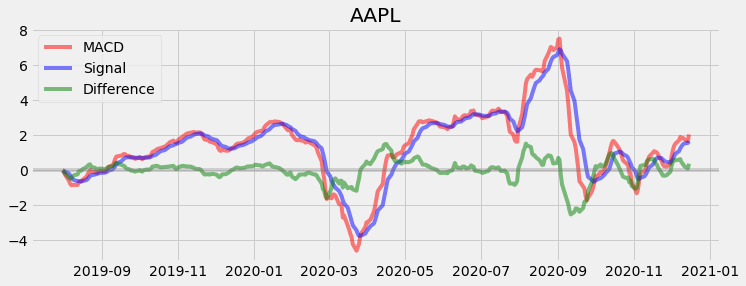

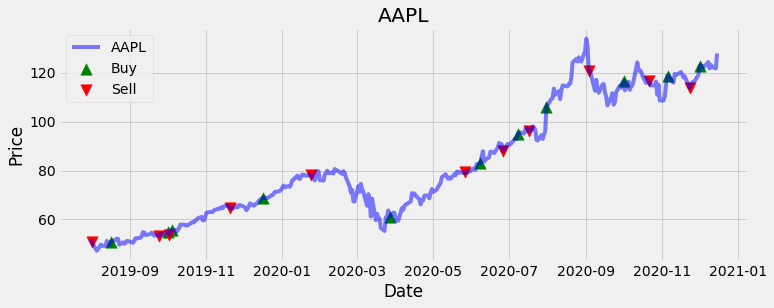

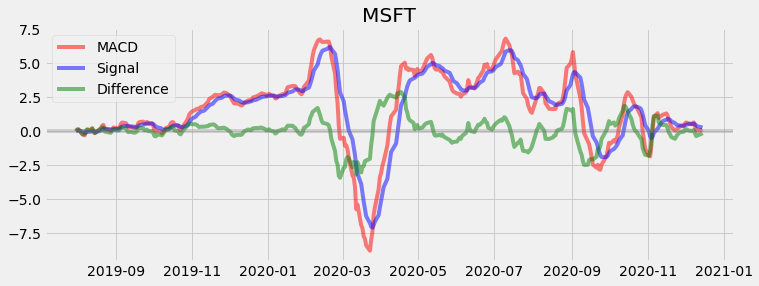

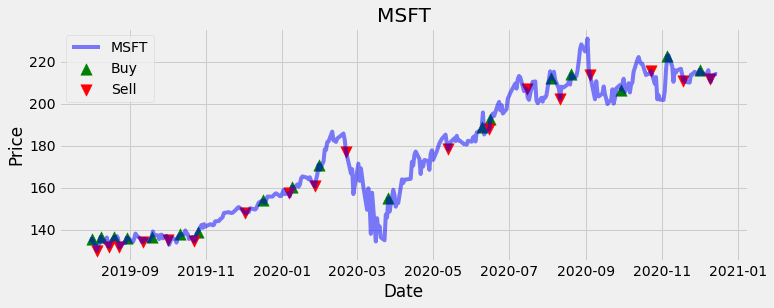

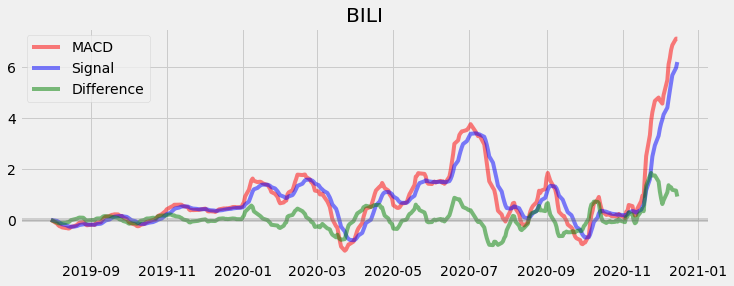

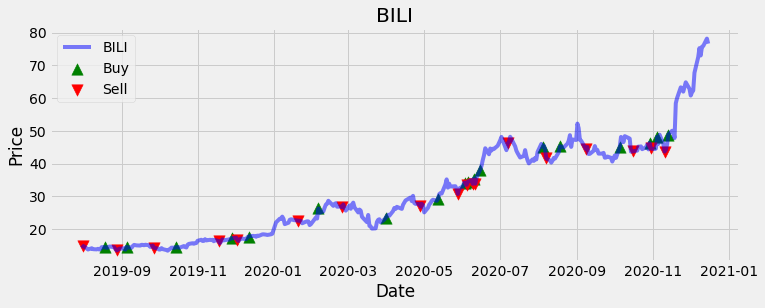

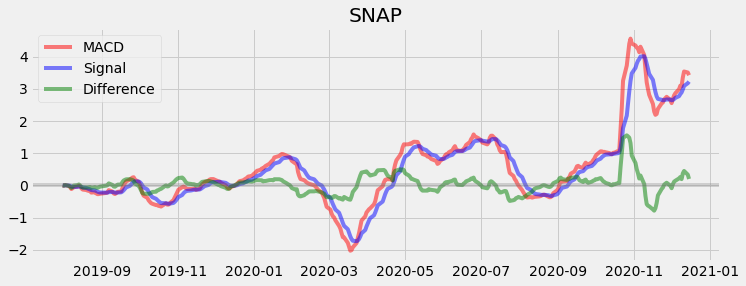

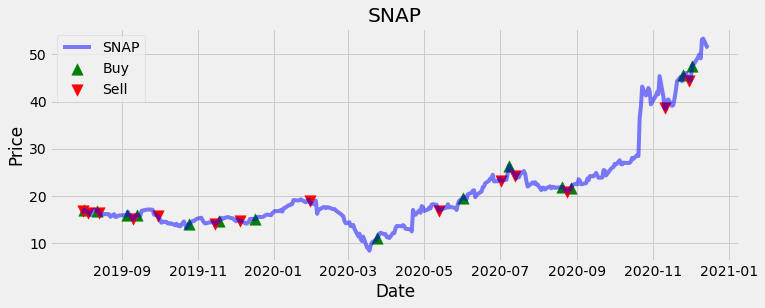

In [16]:
#Function to determine when to buy and sell stocks using MACD analysis
def get_MACD_signal(signal):
    Buy = []
    Sell =[]
    flag = -1
    
    for i in range(0, len(signal)):
        
        #If MACD line crosses the signal line, then buy
        if signal.iloc[i,1] > signal.iloc[i,2]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal.iloc[i,0])
                flag = 1
            else:
                Buy.append(np.nan)
                
        #If signal line crosses the MACD line, then sell
        elif signal.iloc[i,1] < signal.iloc[i,2]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal.iloc[i,0])
                flag = 0
            else:
                Sell.append(np.nan)
        
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return Buy,Sell

#Calculate the MACD and signal line indicators
def calculate_MACD(ticker, plot=True):
    stocks_df = import_stock_data(ticker, two_years_ago, today)

    ShortEMA = 0
    MiddleEMA = 0
    LongEMA = 0
    #Short/Fast Exponential Moving Average (12 Day EMA)
    ShortEMA = stocks_df.ewm(span=12, adjust=False).mean()

    #Long/Slow Exponential Moving Average (26 Day EMA)
    LongEMA = stocks_df.ewm(span=26, adjust = False).mean()

    #Calculate the MACD
    MACD = ShortEMA - LongEMA

    #Calculate the signal line
    signal = MACD.ewm(span=9, adjust=False).mean()

    #Calculate difference between MACD and Signal
    difference = MACD - signal

    #difference_list = []
    #for i in range(0,len(difference)):
        #difference_list.append(difference.iloc[i,0])

    #print(difference_list)
    #print(difference)
    #plt.bar(stocks_df.index, height=difference)

    #x = np.arange(0,len(stocks_df), 1)
    #print(x)

    #Plot the chart
    if plot==True:
        
        plt.figure(figsize=(11,4))
        plt.plot(stocks_df.index, MACD, label= 'MACD', color= 'red', alpha=0.5)
        plt.plot(stocks_df.index, signal, label= 'Signal', color= 'blue', alpha=0.5)
        plt.plot(stocks_df.index, difference,label='Difference', color = "green", alpha=0.5)
        plt.axhline(0, linestyle= '-', color = 'gray', alpha=0.3)
        #plt.fill_between(x,difference_list,0)
        plt.title(ticker)
        plt.legend(loc='upper left')
        plt.show()

        #Create MACD and Signal Line Columns
        stocks_df['MACD'] = MACD
        stocks_df['Signal Line'] = signal
        stocks_df['Difference']= difference

        #Create buy and sell columns
        stocks_df['Buy'], stocks_df['Sell'] = get_MACD_signal(stocks_df)
        #stocks_df

        #Plot the buy and sell signals
        plt.figure(figsize= (11,4))
        plt.plot(stocks_df[ticker], color='blue', alpha=0.5)
        #plt.plot(stocks_df['MACD'], color='orange', alpha=0.5)
        #plt.plot(stocks_df['Signal Line'], color='red', alpha=0.5)
        plt.scatter(stocks_df.index, stocks_df['Buy'], color = 'green', marker= '^', s=130, alpha = 1)
        plt.scatter(stocks_df.index, stocks_df['Sell'], color = 'red', marker= 'v', s=130, alpha = 1)
        plt.title(ticker)
        plt.ylabel('Price')
        plt.xlabel('Date')
        plt.legend([ticker,'Buy','Sell'])
        plt.show()

        return stocks_df

for t in ticker:
    stock_information=calculate_MACD(t,plot=True)
